In [1]:
!pip install sqlalchemy
!pip install pyodbc

In [2]:
from sqlalchemy import create_engine, Table, inspect
import pandas as pd
import pyodbc 
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def new_engine(dialect, server, database, user=None, password=None, integrated_security=True):
    if integrated_security:
        # For Windows authentication
        eng = f"{dialect}://{server}/{database}?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server"
    else:
        assert user, 'You must define a username'
        assert password, 'You must define a password'
        # For SQL Server authentication
        eng = f"{dialect}://{user}:{password}@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server"
    print(eng)
    return create_engine(eng)

In [4]:
engine = new_engine('mssql', 'Taem-pc', 'AdventureWorks2022')

mssql://Taem-pc/AdventureWorks2022?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server


In [5]:
print(type(engine))

<class 'sqlalchemy.engine.base.Engine'>


In [6]:
connection = engine.connect()

In [7]:
print(type(connection))

<class 'sqlalchemy.engine.base.Connection'>


In [8]:
# Top 10 sellers
query ="""
SELECT TOP 10
    st.TerritoryID AS SalesTerritoryID,
    st.Name AS TerritoryName,
    sp.BusinessEntityID AS SellerID,
    CONCAT(p.FirstName, ' ', p.LastName) AS SellerName,
    cr.CountryRegionCode,
    COUNT(soh.SalesOrderID) AS TotalOrders,
    SUM(soh.TotalDue) AS TotalSalesAmount
FROM 
    Sales.SalesOrderHeader soh
JOIN 
    Sales.SalesTerritory st ON soh.TerritoryID = st.TerritoryID
JOIN 
    Sales.SalesPerson sp ON soh.SalesPersonID = sp.BusinessEntityID
JOIN 
    HumanResources.Employee e ON sp.BusinessEntityID = e.BusinessEntityID
JOIN 
    Person.BusinessEntityAddress bea ON e.BusinessEntityID = bea.BusinessEntityID
JOIN 
    Person.Address a ON bea.AddressID = a.AddressID
JOIN 
    Person.StateProvince spc ON a.StateProvinceID = spc.StateProvinceID
JOIN 
    Person.CountryRegion cr ON spc.CountryRegionCode = cr.CountryRegionCode
JOIN 
    Person.Person p ON p.BusinessEntityID = sp.BusinessEntityID
GROUP BY 
    st.TerritoryID, st.Name, sp.BusinessEntityID, p.FirstName, p.LastName, cr.CountryRegionCode
ORDER BY 
    TotalSalesAmount DESC;

"""
joinn_df = pd.read_sql(sql=query, con=connection)
print (joinn_df.head(20))
 


   SalesTerritoryID   TerritoryName  SellerID                SellerName  \
0                 6          Canada       289                   Jae Pak   
1                 5       Southeast       279               Tsvi Reiter   
2                 4       Southwest       276            Linda Mitchell   
3                 4       Southwest       281                   Shu Ito   
4                 7          France       290  Ranjit Varkey Chudukatil   
5                 2       Northeast       277            Jillian Carson   
6                10  United Kingdom       282              José Saraiva   
7                 1       Northwest       283            David Campbell   
8                 6          Canada       278            Garrett Vargas   
9                 4       Southwest       275            Michael Blythe   

  CountryRegionCode  TotalOrders  TotalSalesAmount  
0                GB          348      9.585125e+06  
1                US          429      8.086074e+06  
2              

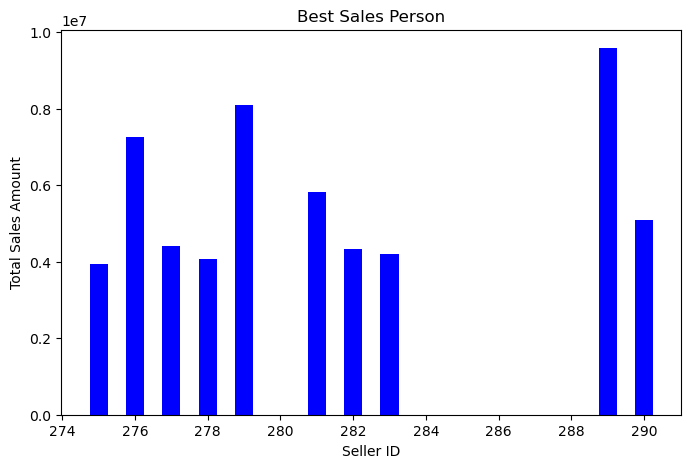

In [37]:
# bar plot Top 10 sellers via SellerID
plt.figure(figsize=(8, 5))
plt.bar(joinn_df['SellerID'], joinn_df['TotalSalesAmount'], color='blue', width=0.5)
plt.title('Best Sales Person')
plt.xlabel('Seller ID')
plt.ylabel('Total Sales Amount')

plt.show()


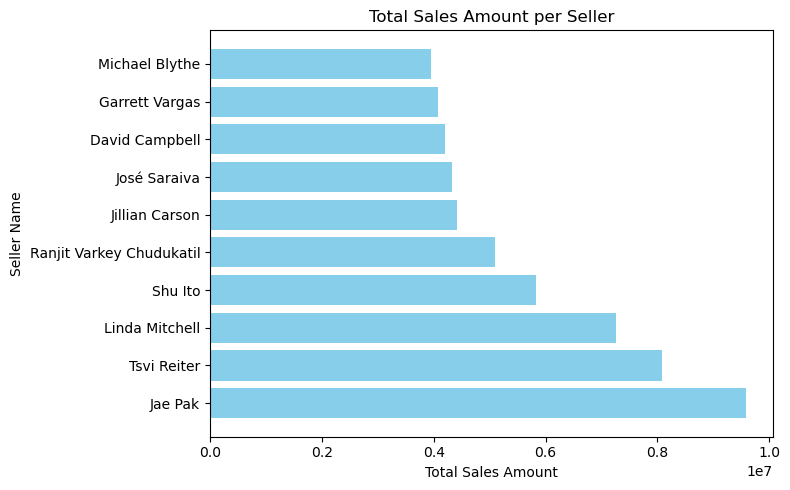

In [38]:
# bar plot Top 10 sellers via Seller Namn
plt.figure(figsize=(8, 5))
plt.barh(joinn_df['SellerName'], joinn_df['TotalSalesAmount'], color='skyblue')
plt.xlabel('Total Sales Amount')
plt.ylabel('Seller Name')
plt.title('Total Sales Amount per Seller')
plt.tight_layout()

plt.show()

In [11]:
# mean and standard deviation
mean_sales = np.mean(joinn_df['TotalSalesAmount'])
std_dev_sales = np.std(joinn_df['TotalSalesAmount'])

# standard error
std_error = std_dev_sales / np.sqrt(len(joinn_df['TotalSalesAmount']))

# confidence (for 95% confidence interval)
confidence_level = 0.95

#  the critical value (z-score) based on the confidence level
# For 95% confidence level, the critical value is 1.96 (for a large sample size)
# For smaller sample sizes or different confidence levels, this value might change
critical_value = np.abs(1 - confidence_level) / 2 + confidence_level

# margin of error
margin_of_error = critical_value * std_error

# confidence interval
lower_bound = mean_sales - margin_of_error
upper_bound = mean_sales + margin_of_error

print(f"Mean Sales: {mean_sales:.2f}")
print(f"Standard Deviation: {std_dev_sales:.2f}")
print(f"Standard Error: {std_error:.2f}")
print(f"Confidence Interval ({confidence_level * 100}%): ({lower_bound:.2f}, {upper_bound:.2f})")


Mean Sales: 5682587.64
Standard Deviation: 1873390.78
Standard Error: 592418.18
Confidence Interval (95.0%): (5104979.91, 6260195.37)


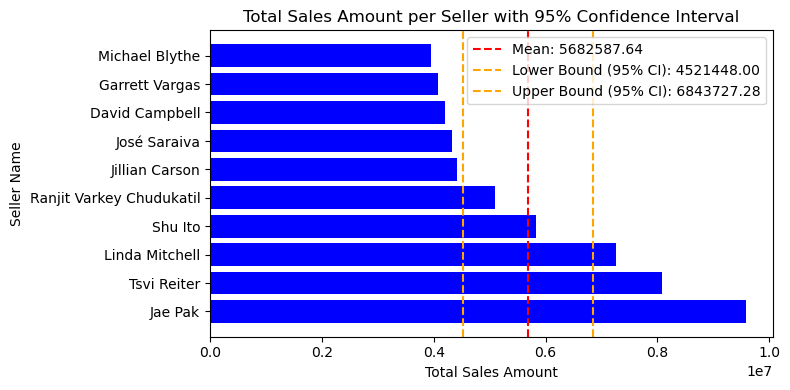

In [34]:
# mean and standard deviation
mean_sales = np.mean(joinn_df['TotalSalesAmount'])
std_dev_sales = np.std(joinn_df['TotalSalesAmount'])

# confidence interval for 95%  
confidence = 1.96  # 95% confidence interval
lower_bound = mean_sales - confidence * std_error
upper_bound = mean_sales + confidence * std_error

# Horizontal bar plot
plt.figure(figsize=(8, 4))
plt.barh(joinn_df['SellerName'], joinn_df['TotalSalesAmount'], color='blue')

plt.xlabel('Total Sales Amount')
plt.ylabel('Seller Name')
plt.title('Total Sales Amount per Seller with 95% Confidence Interval')

# mean, lower bound, and upper bound 
plt.axvline(x=mean_sales, color='red', linestyle='--', label=f'Mean: {mean_sales:.2f}')
plt.axvline(x=lower_bound, color='orange', linestyle='--', label=f'Lower Bound (95% CI): {lower_bound:.2f}')
plt.axvline(x=upper_bound, color='orange', linestyle='--', label=f'Upper Bound (95% CI): {upper_bound:.2f}')
plt.legend()
plt.tight_layout()

plt.show()
